<a href="https://colab.research.google.com/github/saarangmahun/comp215/blob/main/labs/lab06_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6
----------------
#### Name(s): Saarang Singh Mahun
#### Date: Feb 26 2025

By the end of this lab you should be able to:
  * create a Watts-Strogatz graph both from scratch and from the Networkx module
  * measure the average clustering coefficient and path length of a network
  * visualize summative data of a graph


During this lab, you will be introduced to the following:
  * numpy arrays
  * local file i/o in Google Colab

(this lab is based on workbooks provided in Allen Downey's 'Think Complexity')

## Social Networking

This lab uses graphs to explore social networks using Facebook data.  In this lab you will create a simulated model of the network using a Watts-Strogatz graph and compare some properties of the simulated network and the real Facebook network.

In [ ]:
# put your imports here

In [ ]:
import numpy as np
import networkx as nx
import random
from collections import deque

## Get the Facebook Data

Stanford Network Analysis Platform (SNAP) is a general purpose network analysis and graph mining library.  In previous labs, we have used APIs to access data.  For this lab, we will copy the data to a local file.  Download the ```facebook_combined.txt.gz``` file from [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html), unzip it, and copy ```facebook_combined.txt``` to the ```Files``` folder in Colab.  

Look at the content of the file and read the SNAP webpage to understand what the data represents before moving on to the rest of the lab.

## Exercise 1: Make Facebook Graph

Write a function that reads the file, one edge per line, specified by the two integer node IDs given in each line of the file and returns a ```networkx``` graph representing the data.  You can do this with Python's built-in file handling, or you could use ```numpy```'s ```loadtxt``` function.  Write a unit test to check that the network has 4039 nodes and 88234 edges (as given in the Dataset Statistics on the SNAP site) and draw the Facebook network (this takes about a minute).


E
ERROR: /root/ (unittest.loader._FailedTest./root/)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute '/root/'

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (errors=1)


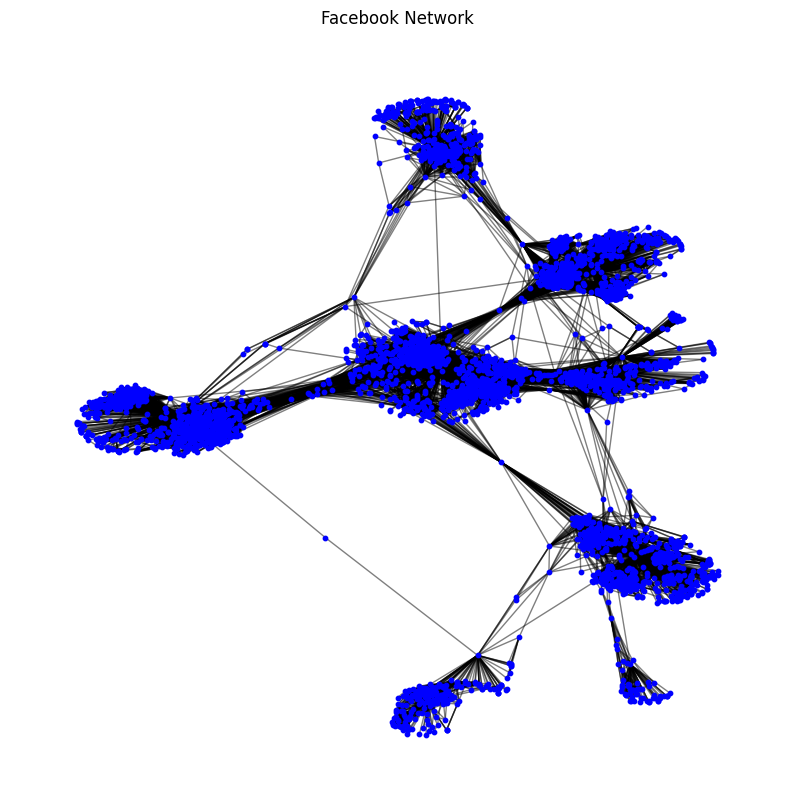

In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import unittest

def make_facebook_graph(file_path):
    """
    Open a file where each line has two numbers (an edge) and build an undirected graph.
    """
    G = nx.Graph()
    with open(file_path, 'r') as f:
        for line in f:
            # Split the line into two parts (the two node IDs)
            parts = line.strip().split()
            if len(parts) == 2:
                u, v = map(int, parts)
                G.add_edge(u, v)
    return G

def draw_facebook_network(G):
    """
    Draw the graph using a spring layout.
    I think it takes time for larger graphs.
    """
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)  # Use a fixed seed for the same layout each time
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue')
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title("Facebook Network")
    plt.axis("off")
    plt.show()

# A simple test to check if the graph has the right number of nodes and edges.
class TestFacebookGraph(unittest.TestCase):
    def test_graph_properties(self):
        file_path = "facebook_combined.txt"
        G = make_facebook_graph(file_path)
        self.assertEqual(len(G.nodes()), 4039)
        self.assertEqual(len(G.edges()), 88234)

if __name__ == "__main__":
    # Run the test
    unittest.main(exit=False)

    # Create and draw the Facebook graph
    G = make_facebook_graph("facebook_combined.txt")
    draw_facebook_network(G)


## Exercise 2: Clustering Coefficients

With larger graphs, it can take a long time to compute clustering coefficients and path lengths. We can estimate them by sampling without much loss of accuracy if the sample size is large enough.  Write a function that calculates the average clustering coeffient for a random subset of a N nodes in a network.  You may use the ```node_clustering``` and ```all_pairs``` functions from Chapter 5 of the textbook.  You may also use the ```numpy``` module to calculate the mean; note that there is a ```nanmean``` function.

Check that your clustering coeffients function gives a similar answer to the ```networkx``` ```average_clustering``` function.


In [3]:
import numpy as np
import networkx as nx
import random

def node_clustering(G, node):
    # Get the node's neighbors.
    neighbors = list(G.neighbors(node))
    degree = len(neighbors)
    # If there are less than 2 neighbors, return 0.
    if degree < 2:
        return 0.0
    links = 0
    # Count edges between neighbors.
    for i in range(degree):
        for j in range(i + 1, degree):
            if G.has_edge(neighbors[i], neighbors[j]):
                links += 1
    # Calculate and return the clustering value.
    return (2.0 * links) / (degree * (degree - 1))

def average_sampled_clustering(G, sample_size):
    # Pick some random nodes.
    sample_nodes = random.sample(list(G.nodes()), sample_size)
    # Get clustering for each picked node.
    clustering_values = [node_clustering(G, node) for node in sample_nodes]
    # Return the average clustering.
    return np.nanmean(clustering_values)

if __name__ == "__main__":
    # Read the file and build the graph.
    file_path = "facebook_combined.txt"
    G = nx.read_edgelist(file_path, nodetype=int)

    sample_size = 100  # Number of random nodes to use
    avg_sampled = average_sampled_clustering(G, sample_size)
    avg_networkx = nx.average_clustering(G)

    print("Average clustering (sampled):", avg_sampled)
    print("Average clustering (networkx):", avg_networkx)



Average clustering (sampled): 0.5778041954699118
Average clustering (networkx): 0.6055467186200876


## Exercise 3: Average Shortest Path Length

Write a function that calculates the average shortest path length for all pairs of nodes in a network.  You may use the ```shortest_path_dijkstra``` function from Chapter 5 of the textbook.  Using that function, it took my algorithm about 2 minutes to find the average shortest path over all pairs of nodes.


Check that your average shortest path length function gives a similar answer to the ```networkx``` ```average_shortest_path_length``` function.


In [4]:
import networkx as nx

def my_average_shortest_path_length(G):
    # Start total distance and pair count at 0.
    total_distance = 0
    pair_count = 0
    # Go through every node in the graph.
    for source in G.nodes():
        # Get distances from this node to all others using Dijkstra's algorithm.
        lengths = nx.single_source_dijkstra_path_length(G, source)
        # For each other node, add the distance and count the pair.
        for target, dist in lengths.items():
            if source != target:
                total_distance += dist
                pair_count += 1
    # Return the average distance.
    return total_distance / pair_count

if __name__ == "__main__":
    # Read the file and build the graph.
    file_path = "facebook_combined.txt"
    G = nx.read_edgelist(file_path, nodetype=int)

    # Compute average shortest path with our function.
    my_avg = my_average_shortest_path_length(G)
    # Compute average shortest path with networkx.
    nx_avg = nx.average_shortest_path_length(G)

    print("Average shortest path (our method):", my_avg)
    print("Average shortest path (networkx):", nx_avg)

  #OMG THAT TOOK 6m 17s TO RENDER! Maybe because of my laptop?


Average shortest path (our method): 3.6925068496963913
Average shortest path (networkx): 3.6925068496963913


Here is a function from the textbook that takes a sample of path lengths to estimate the average shortest path length.  You may use this in the rest of the lab so that you don't need to wait for the whole full averaging algorithms above to run.

In [ ]:

def sample_path_lengths(G, nodes=None, trials=100):
    """Choose random pairs of nodes and compute the path length between them.
    G: Graph
    N: number of pairs to choose
    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

In the exercises above, you should have found that the Facebook network has an average clustering coefficient around 0.6 and an average shortest path length of around 3.7. Note that this corresponds to a 'degree of separation' of less than 6.   

## Exercise 4: WS Graph

Construct a WS graph with the same number of nodes and average degree as the Facebook network using the ```make_ws_graph``` function from Chapter 5.  Find the value of p (probability of rewire) that reproduces a clustering coefficient and average shortest path length of the Facebook network.  (Note that there is a ```nx.watts_strogatz_graph``` that you may use after you have demonstrated that you can create a WS graph using the functions from Chapter 5.).

What could this value of p tell you about the actual social network that this Facebook data represents?  (Think about what p means in the model and what that would represent in the data.)

In [8]:
import numpy as np
import networkx as nx
import random

def sample_path_lengths(G, nodes=None, trials=100):
    # Get all nodes as a list.
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)
    # Pick random pairs of nodes.
    pairs = np.random.choice(nodes, (trials, 2))
    # For each pair, get the shortest path length.
    lengths = [nx.shortest_path_length(G, *pair) for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    # Return the average of the sampled path lengths.
    return np.mean(sample_path_lengths(G, nodes, trials))

def make_ws_graph(n, k, p):
    # Create a Watts-Strogatz graph with:
    # n = number of nodes,
    # k = each node connects to k neighbors,
    # p = chance to rewire an edge.
    return nx.watts_strogatz_graph(n, k, p)

if __name__ == "__main__":
    # Load the Facebook data graph.
    fb_file = "facebook_combined.txt"
    fb = nx.read_edgelist(fb_file, nodetype=int)

    # Get Facebook's average clustering and estimated average shortest path.
    fb_clustering = nx.average_clustering(fb)
    fb_est_path_length = estimate_path_length(fb, trials=1000)

    print("Facebook clustering:", fb_clustering)
    print("Facebook estimated average shortest path:", fb_est_path_length)

    # Set parameters for the WS graph.
    n = fb.number_of_nodes()  # Total nodes (e.g., 4039)
    # Average degree = 2 * number of edges / number of nodes.
    avg_degree = (2 * fb.number_of_edges()) / n
    k = int(round(avg_degree))
    if k % 2 == 1:
        k += 1  # Make k even if it's not already.
    print("WS graph parameters: n =", n, "k =", k)

    # Try different p values to match Facebook's metrics.
    p_values = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]
    for p in p_values:
        ws = make_ws_graph(n, k, p)
        ws_clustering = nx.average_clustering(ws)
        ws_est_path_length = estimate_path_length(ws, trials=1000)
        print("p =", p,
              "WS clustering:", ws_clustering,
              "WS estimated path length:", ws_est_path_length)


    #This time it took about 15 seconds! Hahaha that was fun! As for the answer to the questions, a low p means most friendships happen in close, tight groups, with only a few "bridge" friendships connecting different groups. This suggests that people usually stick with their local circle, but a few random connections keep the whole network closely linked.


Facebook clustering: 0.6055467186200876
Facebook estimated average shortest path: 3.74
WS graph parameters: n = 4039 k = 44
p = 0.0001 WS clustering: 0.7323481861773777 WS estimated path length: 19.549
p = 0.001 WS clustering: 0.7303611842324139 WS estimated path length: 6.963
p = 0.01 WS clustering: 0.7120261755056225 WS estimated path length: 4.143
p = 0.05 WS clustering: 0.6320955589490138 WS estimated path length: 3.264
p = 0.1 WS clustering: 0.5369209046253771 WS estimated path length: 2.964
p = 0.2 WS clustering: 0.3750240095478507 WS estimated path length: 2.811
